# **Install**

In [ ]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9611 sha256=4677640105f3a07c84b46605a5e0dcd24620caf08507951be3aad9e6d3c3d67d
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


# **Imports**

In [ ]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from progress.bar import IncrementalBar
import sys

# **Activation Functions**

In [ ]:
# derivative function, gets function output as input and computer derivative
class Linear:
    def __init__(self):
        self.__name__ = 'linear'

    def __call__(self, Z):
        return Z

    def derivative(self, Z, *args, **kwargs):
        return 1


class Relu:
    def __init__(self):
        self.__name__ = 'relu'

    def __call__(self, Z):

        return Z * (Z > 0)

    def derivative(self, Z, *args, **kwargs):
        return (Z > 0) * 1


class Sigmoid:
    def __init__(self):
        self.__name__ = 'sigmoid'

    def __call__(self, Z):
        return 1 / (1 + np.exp(-Z))

    def derivative(self, Z, *args, **kwargs):
        return Z * (1 - Z)



# stable version of softmax:
class Softmax:
    def __init__(self):
        self.__name__ = 'softmax'

    def __call__(self, Z):
        e = -np.max(Z, axis=1, keepdims=True)
        exp = np.exp(Z + e)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def derivative(self, Z, *args, **kwargs):
        raise Exception('cannot get derivative')


class Tanh:
    def __init__(self):
        self.__name__ = 'tanh'

    def __call__(self, Z):
        return np.tanh(Z)

    def derivative(self, Z, *args, **kwargs):
        return 1 - (np.tanh(Z) ** 2)


sigmoid = Sigmoid
softmax = Softmax
relu = Relu
linear = Linear
tanh = Tanh

In [ ]:
class Static_split:
    def __init__(self, test_split=0.2):
        self.test_split = test_split

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        split = int(X.shape[0] * self.test_split)
        self.X_test = X[p[:split]]
        self.y_test = y[p[:split]]
        self.X_train = X[p[split:]]
        self.y_train = y[p[split:]]

    def get_test_data(self):
        return self.X_test, self.y_test

    def get_train_data(self):
        return self.X_train, self.y_train


class kfold_split:
    def __init__(self, k=5):
        self.k = k

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        self.split = np.random.randint(0, self.k, size=X.shape[0])
        self.X = X
        self.y = y

    def __iter__(self):
        return self.__next__()

    def __next__(self):
        for i in range(self.k):
            yield self.X[self.split != i], self.y[self.split != i], self.X[self.split == i], self.y[self.split == i]

# **Layers**

In [ ]:
class Dense:
    def __init__(self, unit, activation=linear, input_dim=0, trainable=True):
        self.unit = unit
        self.__name__ = 'Dense'
        self.name = "dense"
        self.trainable = trainable
        if type(activation) == str:
            if activation.lower() == 'linear':
                activation = Linear()
            elif activation.lower() == 'sigmoid':
                activation = Sigmoid()
            elif activation.lower() == 'relu':
                activation = Relu()
            elif activation.lower() == 'softmax':
                activation = Softmax()
            elif activation.lower() == 'tanh':
                activation = Tanh()
            else:
                raise Exception("Activation function " + activation + " not found!")

        self.activation = activation
        self.input_dim = input_dim

    def set_name(self, name):
        self.name = name

    def compile(self, input_dim=-1):
        if input_dim == -1:
            assert self.input_dim != 0
        else:
            self.input_dim = input_dim

        self.W = (np.random.random(size=(self.input_dim + 1, self.unit))) - 0.5
        self.W = self.W / (self.W.std() * (input_dim + self.unit) ** 0.5)

    def __call__(self, X, activation=True):
        if activation:
            return self.activation(np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W))
        else:
            return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W)

    def set_trainable(self, trainable):
        self.trainable = trainable

    def update(self, dw):
        if self.trainable:
            self.W = self.W + dw

    def reset_weights(self):
        self.W = (np.random.random(size=self.W.shape)) - 0.5
        self.W = self.W / (self.W.std() * (self.W.shape[0] + self.unit) ** 0.5)


# **Loss Functions**

In [ ]:
class Cross_entropy:
    def __init__(self, last_layer_activation):
        if last_layer_activation == 'sigmoid':
            self.get_loss = self.call_sigmoid
            self.derivative = self.derivative_sigmoid
        elif last_layer_activation == 'softmax':
            self.get_loss = self.call_softmax
            self.derivative = self.derivative_softmax

    def call_sigmoid(self, z, y):
        return np.mean(z * (1 - y) + np.logaddexp(0, -z))

    def derivative_sigmoid(self, h, y):
        return h - y

    def call_softmax(self, z, y):
        return -np.mean(np.sum(y * (z - logsumexp(z, axis=1, keepdims=True)), axis=1))

    def derivative_softmax(self, h, y):
        return h - y

    def get_loss(self, h, y):
        return -np.mean(np.sum(y * np.log(h) + (1 - y) * np.log(1 - h), axis=1))

    def derivative(self, h, y):
        return (h - y) / (h * (1 - h))

    def __call__(self, h, y):
        self.get_loss(h, y)

# **Model**

In [ ]:
class Sequential:
    def __init__(self):
        self.remove_last_layer_activation = False
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.regularization = None
        self.layer_counter = 1

    def add(self, layer):
        layer.set_name('dense_' + str(self.layer_counter))
        self.layer_counter += 1
        self.layers.append(layer)

    def initialize_layers(self):
        input_dim = -1
        for layer in self.layers:
            layer.compile(input_dim)
            input_dim = layer.unit

    def compile(self, optimizer='SGD', loss='cross_entropy', regularization=None):
        if loss.lower() == 'cross_entropy':
            self.loss = Cross_entropy(self.layers[-1].activation.__name__)
            if self.layers[-1].activation.__name__ == "sigmoid" or self.layers[-1].activation.__name__ == "softmax":
                self.remove_last_layer_activation = True

        if type(optimizer) == str:
            if optimizer.lower() == 'sgd':
                optimizer = SGD()
            elif optimizer.lower() == 'momentum_sgd':
                optimizer = Momentum_SGD()
            elif optimizer.lower() == 'adagrad':
                optimizer = Adagrad()
            elif optimizer.lower() == 'rmsprop':
                optimizer = RMSprop()
            elif optimizer.lower() == 'adam':
                optimizer = Adam()
            else:
                raise Exception("Optimizer " + optimizer + " not found!")

        if regularization is not None and type(regularization) == str:
            if regularization.lower() == 'l1':
                regularization = L1()
            elif regularization.lower() == 'l2':
                regularization = L2()

        self.regularization = regularization
        self.optimizer = optimizer


        self.initialize_layers()

    def fit(self, X, y, batch_size=32, epoch=1, test_data=None):
        assert self.loss is not None

        history = {'acc': np.zeros(epoch), 'loss': np.zeros(epoch)}
        if test_data is not None:
            history['val_acc'] = np.zeros(epoch)
            history['val_loss'] = np.zeros(epoch)

        for epch in range(epoch):
            print('Epoch', epch + 1)
            sum_loss = 0
            sum_acc = 0
            bt_conter = 0

            required_batchs = int(X.shape[0] / batch_size + 0.99999999)
            bar = IncrementalBar(max=required_batchs,
                                 suffix='%(index)d/%(max)d - %(eta)ds')

            epoch_shufle = np.random.permutation(X.shape[0])

            for bt in range(0, X.shape[0], batch_size):
                bt_conter += 1
                # single batch:
                X_batch = X[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]
                y_batch = y[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]

                layer_output = [X_batch]
                for j, layer in enumerate(self.layers):
                    layer_output.append(layer(layer_output[-1]))

                delta_next = self.loss.derivative(layer_output[-1], y_batch)
                if not self.remove_last_layer_activation:
                    delta_next *= self.layers[-1].activation.derivative(layer_output[-1])

                grad = [0 for i in range(len(self.layers))]
                regularization_grad = [0 for i in range(len(self.layers))]
                if self.regularization is not None:
                    regularization_grad = self.regularization.derivative(self.layers)

                for i in range(len(self.layers) - 1, 0, -1):
                    delta_prev = np.dot(delta_next, self.layers[i].W.T[:, :-1]) * \
                                 self.layers[i - 1].activation.derivative(layer_output[i])

                    delta_wi = np.dot(np.hstack((layer_output[i], np.ones((layer_output[i].shape[0], 1)))).T,
                                      delta_next)
                    grad[i] = delta_wi / X_batch.shape[0] + regularization_grad[i]

                    delta_next = delta_prev

                delta_wi = np.dot(np.hstack((layer_output[0], np.ones((layer_output[0].shape[0], 1)))).T, delta_next)
                grad[0] = delta_wi / X_batch.shape[0] + regularization_grad[0]

                self.optimizer.update(grad, self.layers)

                d = self.evaluate(X_batch, y_batch)
                loss, acc = d['loss'], d['acc']
                sum_acc += acc
                sum_loss += loss
                bar.next()
                sys.stdout.write(" loss: %f acc: %f" % (sum_loss / (bt_conter + 1), sum_acc / (bt_conter + 1)))
                sys.stdout.flush()

            bar.finish()
            d = self.evaluate(X, y)
            loss, acc = d['loss'], d['acc']
            if test_data is not None:
                d = self.evaluate(test_data[0], test_data[1])
                val_loss, val_acc = d['loss'], d['acc']
                history['val_loss'][epch] = val_loss
                history['val_acc'][epch] = val_acc
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {} val_loss: {} val_acc: {}'.format(loss, acc, val_loss, val_acc))
            else:
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {}'.format(loss, acc))

        return history

    def predict(self, X, batch_size=32, last_activation=True):
        return np.argmax(self.predict_proba(X, batch_size=batch_size, last_activation=last_activation), axis=1)

    def predict_proba(self, X, batch_size=32, last_activation=True):
        output = np.zeros((X.shape[0], self.layers[-1].unit))

        for i in range(0, X.shape[0], batch_size):
            t = X[i:min(i + batch_size, X.shape[0])].copy()
            for j, layer in enumerate(self.layers):
                t = layer(t, activation=(j != len(self.layers) - 1 or last_activation))

            output[i:min(i + batch_size, X.shape[0])] = t

        return output

    def evaluate(self, X, y, batch_size=32):
        if self.loss is not None:
            p = self.predict_proba(X, batch_size=batch_size, last_activation=not self.remove_last_layer_activation)
            loss = self.loss.get_loss(p, y)
            if self.regularization is not None:
                loss += self.regularization.cost(self.layers)

            if self.remove_last_layer_activation:
                p = self.layers[-1].activation(p)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'loss': loss, 'acc': acc}
        else:
            p = self.predict_proba(X, batch_size=batch_size)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'acc': acc}

    def summary(self):
        print("_" * 65)
        print('Layer (type)                 Output Shape              Param #')
        print("=" * 65)

        layer_type = 'Input'
        output_shape = '(None, {})'.format(str(self.layers[0].input_dim))
        params = '0'
        print('{:<29}'.format(layer_type) +
              '{:<26}'.format(output_shape) +
              '{}'.format(params))
        print("-" * 65)

        trainable_params = 0
        non_trainable_params = 0

        for l in self.layers:
            layer_type = l.name + ' ({})'.format(l.__name__)
            output_shape = '(None, {})'.format(str(l.unit))
            params = '{}'.format(l.W.shape[0] * l.W.shape[1])

            if l.trainable:
                trainable_params += l.W.shape[0] * l.W.shape[1]
            else:
                non_trainable_params += l.W.shape[0] * l.W.shape[1]

            print('{:<29}'.format(layer_type) +
                  '{:<26}'.format(output_shape) +
                  '{}'.format(params))
            print("-" * 65)

        print('Total params:', trainable_params + non_trainable_params)
        print('Trainable params:', trainable_params)
        print('Non-trainable params:', non_trainable_params)
        print("_" * 65)
        print('Optimizer : {}'.format(self.optimizer.__name__))
        if self.regularization is not None:
            print('Regularization : {}'.format(self.regularization.__name__))
        print("-" * 65)
        print()
        print()

    def save_weights(self, path):
        import os
        try:
            os.rmdir(path)
        except:
            pass

        os.mkdir(path)

        for i, layer in enumerate(self.layers):
            np.save(os.path.join(path, str(i) + '.npy'), layer.W)

    def load_weights(self, path):
        import os
        assert len(os.listdir(path)) == len(self.layers)

        for i, layer in enumerate(self.layers):
            self.layers[i].W = np.load(os.path.join(path, str(i) + '.npy'))

    def reset_weights(self):
        for layer in self.layers:
            layer.reset_weights()


# === Regularization ===

## **L1 Regularization**
complete this part

In [ ]:
class L1:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L1 Regularization'

    def cost(self, layers):

        cost = 0
        for layer in layers:
            w = layer.W[:-1, :]
            cost += np.sum(np.abs(w))
        return cost * self.lam

    def derivative(self, layers):

        return [self.lam * np.vstack((np.sign(layer.W[:-1, :]), np.zeros((1, layer.W.shape[1])))) for layer in layers]


## **L2 Regularization**
complete this part

In [ ]:
class L2:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L2 Regularization'

    def cost(self, layers):
        cost = 0
        for layer in layers:
            w = layer.W[:-1, :]
            cost += np.sum(np.square(w))
        return cost * self.lam

    def derivative(self, layers):
        # matrix and indicates derivative of each weight with respect to the Regularization term.
        return [2 * self.lam * np.vstack((layer.W[:-1, :], np.zeros((1, layer.W.shape[1])))) for layer in layers]



# === Optimizers ===

## **SGD**

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.__name__ = 'SGD'

    def update(self, grads, layers):
        for layer, delta in zip(layers, grads):
            layer.update(-delta * self.lr)

sgd = SGD()  # Create an instance of the SGD class


##choose best neurons

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 10)                7850
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                110
-----------------------------------------------------------------
Total params: 7960
Trainable params: 7960
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
-----------------------------------------------------------------


Epoch 1
 loss: 1.859433 acc: 0.015625 loss: 2.299104 acc: 0.046875 loss: 2.666353 acc: 0.046875 loss: 2.774678 acc: 0.059375 loss: 2.792868 acc: 0.065104 loss: 2.835311 acc: 0.066964 loss: 2.850361 acc: 0.068359 loss: 2.844193 acc: 0.067708 loss: 2.844053 acc: 0.073438 loss: 2.846

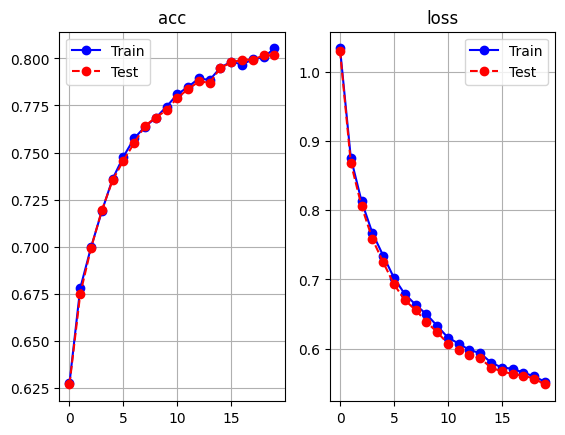

In [ ]:
# 10 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

model = Sequential()
model.add(Dense(10, 'relu', input_dim=X_train.shape[1])) # hidden layer, 10 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='sgd')
model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 30)                23550
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                310
-----------------------------------------------------------------
Total params: 23860
Trainable params: 23860
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
-----------------------------------------------------------------


Epoch 1
 loss: 1.235738 acc: 0.078125 loss: 1.723732 acc: 0.078125 loss: 1.975806 acc: 0.074219 loss: 2.074617 acc: 0.084375 loss: 2.135645 acc: 0.096354 loss: 2.187802 acc: 0.100446 loss: 2.211378 acc: 0.097656 loss: 2.237414 acc: 0.095486 loss: 2.270734 acc: 0.096875 loss: 2.

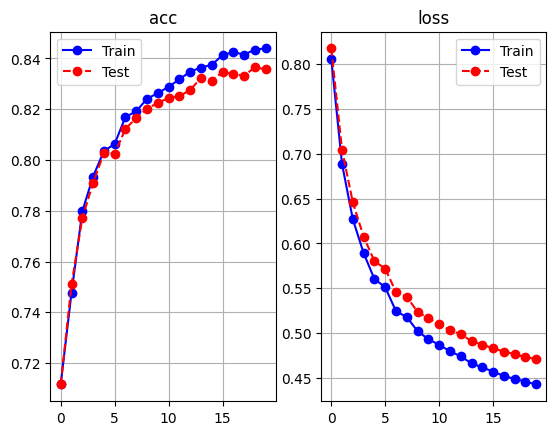

In [ ]:
# 30 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

model = Sequential()
model.add(Dense(30, 'relu', input_dim=X_train.shape[1])) # hidden layer, 30 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='sgd')
model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
-----------------------------------------------------------------


Epoch 1
 loss: 1.264307 acc: 0.054688 loss: 1.664711 acc: 0.067708 loss: 1.847269 acc: 0.074219 loss: 1.951772 acc: 0.071875 loss: 2.014634 acc: 0.088542 loss: 2.044604 acc: 0.087054 loss: 2.089526 acc: 0.095703 loss: 2.116035 acc: 0.104167 loss: 2.133559 acc: 0.107813 loss: 2.

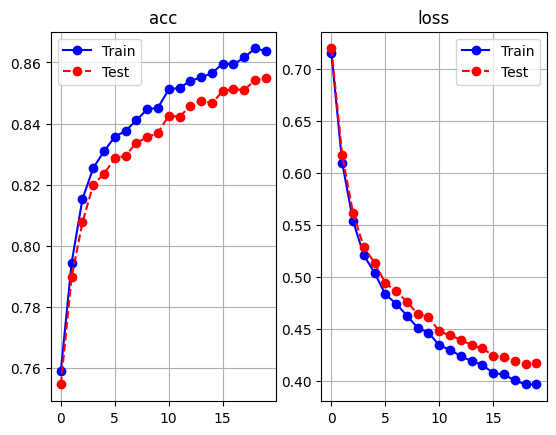

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='sgd')
model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

###**SGD with L2**

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.787085 acc: 0.023438 loss: 2.375641 acc: 0.036458 loss: 2.635010 acc: 0.054688 loss: 2.771360 acc: 0.059375 loss: 2.885080 acc: 0.057292 loss: 2.965289 acc: 0.060268 loss: 2.987912 acc: 0.064453 loss: 3.015445 acc: 0.065972 lo

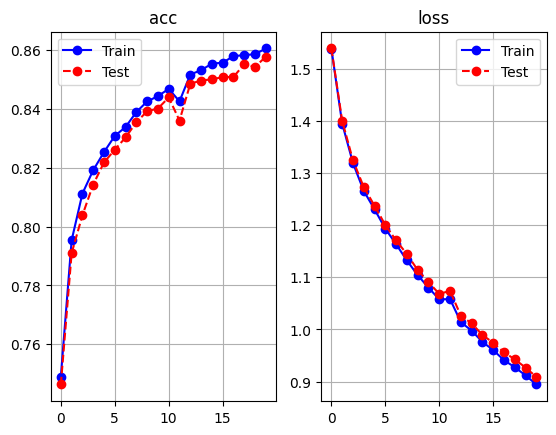

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 75 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='sgd', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

## **Momentum SGD**
complete this part

In [ ]:
class Momentum_SGD(SGD):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum

        # Helping attribute
        self.velocity = None

        self.__name__ = 'Momentum_SGD'

    def update(self, grads, layers):

        if self.velocity is None:
            # Initialize velocity at the first iteration
            self.velocity = [np.zeros_like(grad) for grad in grads]

        for i, (layer, delta) in enumerate(zip(layers, grads)):
            self.velocity[i] = self.momentum * self.velocity[i] - delta * self.lr
            layer.update(self.velocity[i])

        # define Momentum_SGD update rule here.

momentum_sgd = Momentum_SGD()

###**Test Momentum SGD by L2 Regularization**



_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : Momentum_SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.577403 acc: 0.125000 loss: 2.130098 acc: 0.161458 loss: 2.331655 acc: 0.199219 loss: 2.459277 acc: 0.209375 loss: 2.539804 acc: 0.218750 loss: 2.593214 acc: 0.232143 loss: 2.628378 acc: 0.242188 loss: 2.645702 acc: 0.

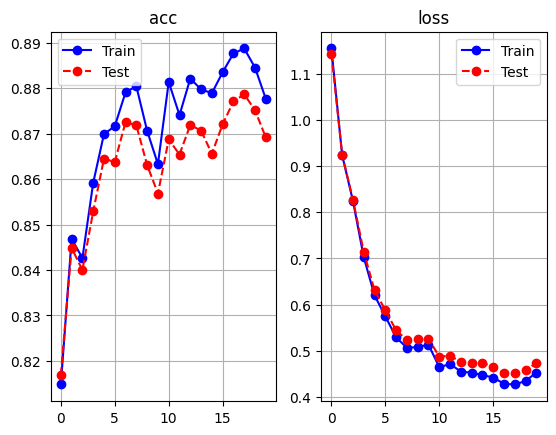

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='momentum_sgd', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

## **Adagrad**


In [ ]:
class Adagrad:
    def __init__(self, lr=0.01):
        self.global_lr = lr
        self.epsilon = 1e-7
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'AdaGrad'

    def update(self, grads, layers):

        if self.velocity is None:
            self.velocity = [np.zeros_like(grad) for grad in grads]
            self.accumulated_gradient = [np.zeros_like(grad) for grad in grads]

        for i, grad in enumerate(grads):
            self.accumulated_gradient[i] += grad ** 2
            self.velocity[i] = np.divide(grad, np.sqrt(self.accumulated_gradient[i] + self.epsilon))

        for layer, delta in zip(layers, self.velocity):
            layer.update(-delta * self.global_lr)

adagrad = Adagrad()

###**Adagrad with L2**



_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.306831 acc: 0.265625 loss: 1.733624 acc: 0.296875 loss: 1.852468 acc: 0.343750 loss: 1.890464 acc: 0.393750 loss: 1.870691 acc: 0.434896 loss: 1.863236 acc: 0.470982 loss: 1.840198 acc: 0.505859 loss: 1.815545 acc: 0.53125

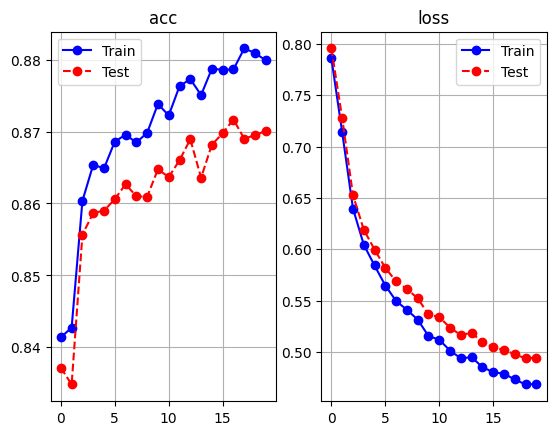

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

## **RMSprop**


In [ ]:
class RMSprop:
    def __init__(self, lr=0.001, rho=0.9):
        self.global_lr = lr
        self.rho = rho
        self.epsilon = 1e-7

        # Helping attribute
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'RMSprop'

    def update(self, grads, layers):


        if self.velocity is None:
            self.velocity = [np.zeros_like(grad) for grad in grads]
            self.accumulated_gradient = [np.zeros_like(grad) for grad in grads]

        for i in range(len(grads)):
            self.accumulated_gradient[i] = self.rho * self.accumulated_gradient[i] + (1 - self.rho) * grads[i] ** 2
            self.velocity[i] = self.global_lr * grads[i] / (np.sqrt(self.accumulated_gradient[i]) + self.epsilon)

        for layer, delta in zip(layers, grads):
            layer.update(-delta * self.global_lr)

        # define RMSprop update rule here.
rmsprop = RMSprop

### ** RMSprop with L2 **



_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : RMSprop
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.617151 acc: 0.023438 loss: 2.175450 acc: 0.052083 loss: 2.424623 acc: 0.066406 loss: 2.565152 acc: 0.071875 loss: 2.669446 acc: 0.088542 loss: 2.744918 acc: 0.089286 loss: 2.811910 acc: 0.089844 loss: 2.853933 acc: 0.08854

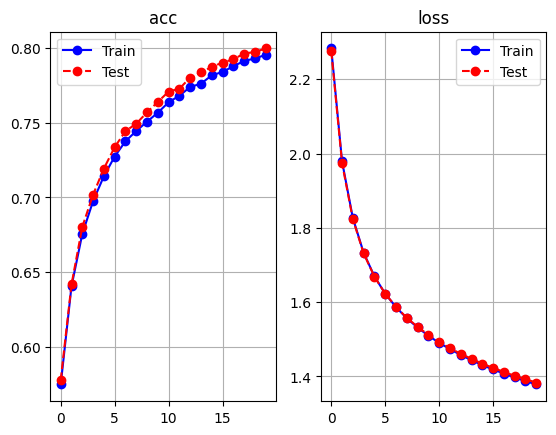

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='rmsprop', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()

## **Adam**



In [ ]:
class Adagrad:
    def __init__(self, lr=0.001):
        self.global_lr = lr

    def update(self, update_step):
        pass

class Adam(Adagrad):
    def __init__(self, lr=0.001, rho_1=0.9, rho_2=0.999, epsilon=1e-8):
        super().__init__(lr=lr)
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        self.epsilon = epsilon

        # Helping attribute
        self.first_moment_estimate = None
        self.second_moment_estimate = None
        self.t = 0
        self.__name__ = 'Adam'

    def update(self, grads, layers):


        if self.first_moment_estimate is None:
            self.first_moment_estimate = [np.zeros_like(grad) for grad in grads]
            self.second_moment_estimate = [np.zeros_like(grad) for grad in grads]

        self.t += 1

        for i, (grad, layer) in enumerate(zip(grads, layers)):
            self.first_moment_estimate[i] = self.rho_1 * self.first_moment_estimate[i] + (1 - self.rho_1) * grad
            self.second_moment_estimate[i] = self.rho_2 * self.second_moment_estimate[i] + (1 - self.rho_2) * (grad ** 2)

            bias_corrected_first_moment = self.first_moment_estimate[i] / (1 - self.rho_1 ** self.t)
            bias_corrected_second_moment = self.second_moment_estimate[i] / (1 - self.rho_2 ** self.t)


            update_step = -self.global_lr * bias_corrected_first_moment / (np.sqrt(bias_corrected_second_moment) + self.epsilon)

            layer.update(update_step)

adam = Adam()


### ** Adam with L2 **

complete and run this part to test optimizer

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.513133 acc: 0.101562 loss: 2.005336 acc: 0.130208 loss: 2.267853 acc: 0.132812 loss: 2.380518 acc: 0.162500 loss: 2.442695 acc: 0.166667 loss: 2.473608 acc: 0.200893 loss: 2.494195 acc: 0.236328 loss: 2.496981 acc: 0.267361 l

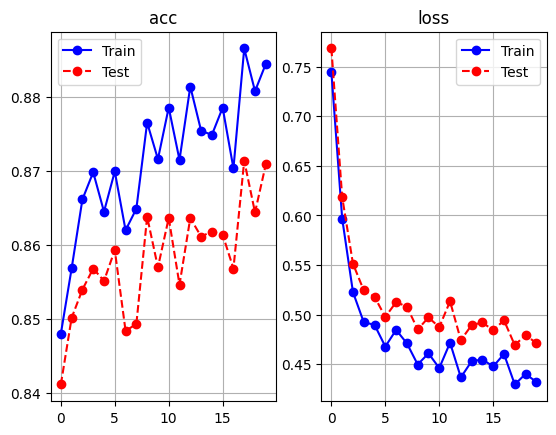

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='adam', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()


**Test Best Optimizer with another regularization**



_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 4.306613 acc: 0.054688 loss: 5.730609 acc: 0.088542 loss: 6.377219 acc: 0.101562 loss: 6.767577 acc: 0.115625 loss: 6.999539 acc: 0.132812 loss: 7.151220 acc: 0.149554 loss: 7.254322 acc: 0.175781 loss: 7.318789 acc: 0.196181 l

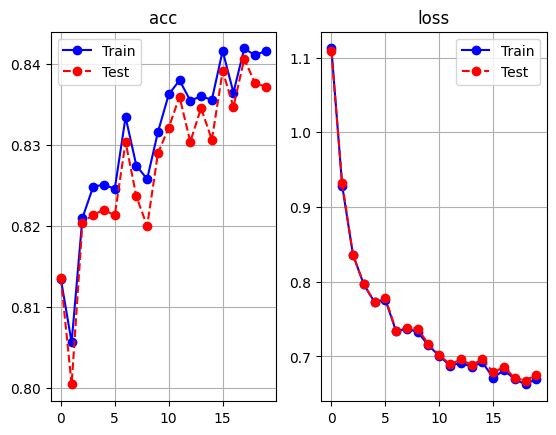

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='adam', regularization='l1')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()


# Test best model : adam with L2

use your best model and run that on test dataset, report final accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 80)                62800
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                810
-----------------------------------------------------------------
Total params: 63610
Trainable params: 63610
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
 loss: 1.712624 acc: 0.093750 loss: 2.253739 acc: 0.104167 loss: 2.484030 acc: 0.101562 loss: 2.603385 acc: 0.103125 loss: 2.654744 acc: 0.125000 loss: 2.685148 acc: 0.151786 loss: 2.701916 acc: 0.179688 loss: 2.707635 acc: 0.199653 l

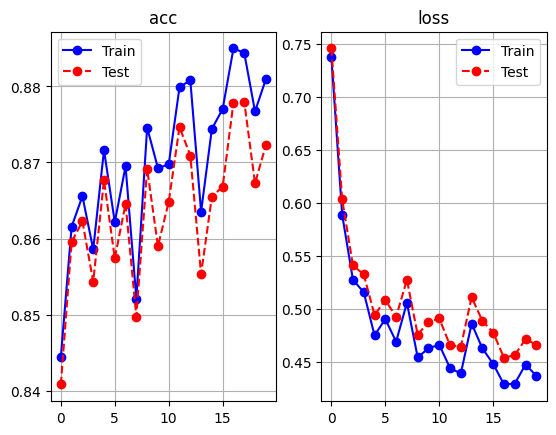

In [ ]:
# 80 neurons
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import utils

def load_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset()

# Convert pixel values from integers to floats and normalize them between 0 and 1

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(len(X_train), (len(X_train[0]))**2)
X_test = X_test.reshape(len(X_test), (len(X_test[0]))**2)
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


model = Sequential()
model.add(Dense(80, 'relu', input_dim=X_train.shape[1])) # hidden layer, 80 neurons with relu activation function and L2 Regularization
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function
model.compile(loss='cross_entropy', optimizer='adam', regularization='l2')

model.summary()

split_data = Static_split(test_split=0.2)
split_data.set_data(X_train, y_train)
(X_train_new, y_train_new) = split_data.get_train_data()
(X_val, y_val) = split_data.get_test_data()

history = model.fit(X_train_new, y_train_new, epoch=20, batch_size=64, test_data=(X_val, y_val))
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend(loc='best')
plt.show()